In [ ]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Electricity consumption prediction
# Contributors: Jeong Gukho, Jeong Woogun, Kim Hyungeun, Kim Juneon, Kimm Soo Min
# Last modified date: 01/04/25

### **Library**

In [17]:
# Library
# Time
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm

# File
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image
import random
import chardet

# Numerical & Data Handling
import numpy as np
import pandas as pd
import scipy as sp
import math

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from sklearn.tree import plot_tree
from scipy.optimize import curve_fit

# Machine Learning Libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
							  ExtraTreesClassifier, ExtraTreesRegressor, 
							  BaggingClassifier, BaggingRegressor, 
							  GradientBoostingClassifier, GradientBoostingRegressor, 
							  AdaBoostClassifier, AdaBoostRegressor, 
							  VotingClassifier, VotingRegressor,
							  StackingClassifier, StackingRegressor)
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from mlxtend.frequent_patterns import apriori, association_rules
from xgboost import XGBClassifier, XGBRegressor

# Neural Network Libraries
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import huggingface
import keras
import tensorflow
from transformers import pipeline

# Feature Engineering
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer, 
								   LabelEncoder, OneHotEncoder, OrdinalEncoder, LabelBinarizer)
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from mlxtend.preprocessing import TransactionEncoder
from hyperopt import hp, tpe, fmin, Trials

# Dimensionality Reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Time-Series Analysis
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation
from sklearn.metrics import (classification_report, pairwise_distances, silhouette_score, 
							 roc_curve, auc, roc_auc_score, RocCurveDisplay, 
							 confusion_matrix, ConfusionMatrixDisplay, 
							 accuracy_score, recall_score, precision_score, f1_score,
							 log_loss, hinge_loss, mean_absolute_error, mean_squared_error, r2_score)
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix, MeanSquaredError, MeanAbsoluteError, R2Score, MetricCollection
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor


### **Data Preparation**

**Data source**

1. 한국전력공사(KEPCO) - https://bigdata.kepco.co.kr/cmsmain.do?scode=S01&pcode=000171&redirect=Y
2. 기상청 - https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36


**Electricity consumption**
- 840 samples in total
- Jan 2015 to Dec 2024
- 7 different locations
 	- Seoul
	- Incheon
	- Daejeon 
	- Daeguu
	- Ulsann
	- Gwangju
	- Busan
- 9 Features
	- Year
	- Month
	- Province
	- Number of Households
	- Avg Power Consumption per Household (kWh)
	- Avg Electricity Bill per Household (KRW)
	- Number of Tropical Nights
	- Number of Heatwave Days
	- Number of Coldwave Days

In [19]:
# Load electricity consumption data
df_electricity = pd.read_csv('data/electricity_consumption_eng.csv', encoding='utf-8')
df_electricity.info()

**Weather forecast**
- 861 samples in total
- Jan 2015 to Feb 2025
- 7 different locations
 	- Seoul
	- Incheon
	- Daejeon 
	- Daegu
	- Ulsan
	- Gwangju
	- Busan
- 21 Features
	- Station Name                  
	- Year                            
	- Month                          
	- Avg Temperature (Celsius)      
	- Avg Max Temperature (Celsius) 
	- Avg Min Temperature (Celsius) 
	- Avg Local Pressure (hPa)      
	- Avg Sea Level Pressure (hPa)  
	- Avg Vapor Pressure (hPa)      
	- Avg Dew Point Temp (Celsius)  
	- Avg Relative Humidity (%)     
	- Monthly Precipitation (mm)    
	- Small Pan Evaporation (mm)    
	- Avg Wind Speed (m/s)          
	- Max Wind Speed (m/s)          
	- Avg Cloud Cover (1/10)        
	- Total Sunshine Hours (hr)     
	- Sunshine Rate (%)             
	- Total Solar Radiation (MJ/m^2)
	- Avg Min Surface Temp (Celsius)
	- Avg Ground Temp (Celsius) 

In [20]:
# Load weather forecast data
df_weather = pd.read_csv('data/weather_forecast_eng.csv', encoding='utf-8')
df_weather.info()

In [4]:
# Check missing values
print(df_weather.isnull().sum())

In [22]:
# Handle missing values w/ ffill
df_weather.ffill(inplace=True)

In [23]:
# Re-check missing values
print(df_weather.isnull().sum())

In [24]:
# Create Date column using Year and Month columns
df_electricity['Date'] = pd.to_datetime(arg=dict(year=df_electricity['Year'], month=df_electricity['Month'], day=1))
df_weather['Date'] = pd.to_datetime(arg=dict(year=df_weather['Year'], month=df_weather['Month'], day=1))

# Drop Year and Month columns
df_weather = df_weather.drop(columns=['Year', 'Month'])

# Rename Station Name and Province to Location
df_electricity = df_electricity.rename(columns={'Province': 'Location'})
df_weather = df_weather.rename(columns={'Station Name': 'Location'})

# Merge df_weather and df_electricity based on Date and Location
df_merged = pd.merge(df_electricity, df_weather, on=['Date', 'Location'], how='inner') # Inner join based on Date and Location
df_merged = df_merged[['Date'] + [col for col in df_merged.columns if col != 'Date']] # Bring Date column to the front
df_merged.to_csv('data/merged_data.csv', index=False, encoding='utf-8')

### **EDA**

In [26]:
def dual_features_plot(a: str, b: str, c: str):
	'''
	This function generates a dual-axis plot to visualize a and b averaged on c.

	Parameters:
	a (str): Column name for data in the DataFrame to compare.
	b (str): Column name for data in the DataFrame to compare.
	c (str): Column name for data in the DataFrame to set average on.

	Output:
	A dual-axis plot with bars of a and an line of b averaged on c.
	'''
	if c == 'Month':
		data = df_merged.groupby(c)[[a, b]].mean().reset_index()
	elif c == 'Year':
		data = df_merged.groupby(c)[[a, b]].sum().reset_index()
		
	fig, ax_1 = plt.subplots(figsize=(12, 8))
	ax_1.set_xlabel(f'{c}')
	ax_1.set_ylabel(f'{a}')
	ax_1.bar(data[c], data[a], color='orange')
	ax_1.tick_params(axis='y', labelcolor='orange')
	#######
	ax_2 = ax_1.twinx()
	ax_2.set_ylabel(f'{b}')
	ax_2.plot(data[c], data[b], marker='o', color='blue')
	ax_2.tick_params(axis='y', labelcolor='blue')
	for x_val,y_val in zip(data[c],data[b]):
		ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=9,color='black')
	plt.title(f'{a} & {b} from 2015 to 2024')
	plt.grid()
	plt.tight_layout()

	plt.show()

In [27]:
def one_feature_two_group (a: str, b: str, c: str): #a: Main Category b:Subcategory c:feature ex)서울, 감수량,가구
	"""
	Plots the mean of a single feature 'c' grouped by two categorical variables 'a' and 'b'.
	
	Parameters:
	a (str): Name of the main category column in df_merged (e.g., a higher-level group like 'Region').
	b (str): Name of the subcategory column in df_merged (e.g., a more granular group like 'City').
	c (str): Name of the feature/metric column whose mean is to be plotted (e.g., 'Sales').
	"""
	df_mean=df_merged.groupby([f'{a}',f'{b}'])[c].mean()
	plt.figure(figsize=(12, 8))
	unstacked_df = df_mean.unstack(level=f'{a}')
	unstacked_df .plot(kind='line',marker='o',ax=plt.gca())

	plt.xlabel(f'{b}')
	plt.ylabel(f'{c}')
	plt.grid()
	plt.title(f'{c} by {a} and {b}')

In [10]:
# #filterheatmap
# df_numeric=df_merged.select_dtypes(include=['number'])
# df_corr=X_train.corr()
# filter_corr=df_corr[abs(df_corr)>=0.8]
# plt.figure(figsize=(20,20))
# sns.heatmap(filter_corr, annot=True,vmin=-1, cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()

In [29]:
# Heatmap
df_numeric=df_merged.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [30]:
#heatmap
df_numeric=df_merged.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
df_corr=df_corr.loc[['Avg Power Consumption per Household (kWh)']]
#filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,1))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap on Target')
plt.show()

In [32]:
# Monthly awaitvg electricity consumption

ele_plt = df_merged.groupby('Month')['Avg Power Consumption per Household (kWh)'].mean()

plt.figure(figsize=(7, 5))
ele_plt.plot(kind='line', marker='o')
plt.title("Monthly Average Electricity Consumption from 2015 to 2024")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.xticks(np.arange(0,13,1),rotation=0)
plt.grid()
plt.show()

In [ ]:
# Monthly average electricity consumption + temperture

avg_t_mean = df_merged.groupby('Month')['Avg Temperature (Celsius)'].mean()
avg_pc_mean = df_merged.groupby('Month')['Avg Power Consumption per Household (kWh)'].mean()

fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white') 
ax = fig.add_subplot()
 
ax.bar(avg_t_mean.index, avg_t_mean , label='Avg Temperature (Celsius)')
ax.set_ylabel('Avg Temperature (Celsius)', fontsize=14, color='black') 
ax.set_xlabel('Month', fontsize=14, color='black')
 
ax2 = ax.twinx()
ax2.set_ylabel('Avg Power Consumption per Household (kWh)', fontsize=14, color='red')
ax2.plot(avg_pc_mean.index ,avg_pc_mean, label='Avg Power Consumption per Household (kWh)',color='red', linewidth = 5)

plt.xticks(np.arange(0,13,1),rotation=0)
plt.title('Avg Temperature & Avg Power Consumption per Household (kWh)',fontsize=20)
plt.legend(loc = 2, fontsize=20, frameon=True, shadow=True)

plt.show()

In [33]:
# Monthly Avg electricity consumption boxplot

plt.figure(figsize=(10, 8))
sns.boxplot(data=df_merged, x='Month', y='Avg Power Consumption per Household (kWh)')
plt.title("Monthly Avg electricity consumption(2015~2024)")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.show()

In [34]:
# Monthly temperature plot
dual_features_plot(a='Avg Temperature (Celsius)', b='Monthly Precipitation (mm)', c='Month')


In [36]:
# #Year per: 84 Month per: 70 Location per: 140 Total data:840
# 
monthly_data = df_merged.groupby('Location')['Avg Power Consumption per Household (kWh) Household (kWh)'].mean( ).reset_index()
df_mean=df_merged.groupby(['YeaAvg Power Consumption per Household (kWh)r Househol# d (kWh)'].mean()
unstacked_df = df_mean.unst# ack(level='Year')
fig, ax_1 = plt.subplot# s(figsize=(12, 8))
ax_1.set# _xlabel('Location')
ax_1.set_xticks# (monthly_data.indAvg Power Consumption per Household (kWh)on # per Household (kWh)')
ax_1.plot(monthly_data['LocAvg Power Consumption per Household (kWh)'on per Household (kWh)'], color='orange',mark# er='o', ms=4,alpha=1)

ax_1.tick_params(axis='# y', labe# lcolor='orange')
### #####
ax_2 = ax_Small Pan Evaporation (mm)('S# mall Pan Evaporation (mm)')
unstacked_df.plot(k# ind='bar',ax=ax_2,alpha=0.5)
ax_2.tick_params(# axis='y', labelcolor='blue')

plt.title(f'Avg Power Consumption per Household#  (kWh) from#  Location,Location'# )
plt.grid()
plt.tight_layout()
for x_val,y_val in zip(monthly_data['Location'],monthly_data['Avg Power C# onsumption per Household (kWh)']):
	ax_1.text(x_val, y_val +0.1,f'{y_val:.2f}',ha='center',va='bottom'# ,fontsize=9,color='black',zorde# r=5)
plt.subplots_adjust(right=1.8)
plt.show()Monthly Precipitation (mm)

In [37]:
# Number of heatwave days and avg power consumption per household by year
dual_features_plot(a='Small Pan Evaporation (mm)',b='Avg Relative Humidity (%)',c='Month')

In [38]:
# Number of heatwave days and avg power consumption per household by year
dual_features_plot(a='Number of Heatwave Days',b='Avg Power Consumption per Household (kWh)',c='Month')


TypeError: 'Legend' object is not iterable

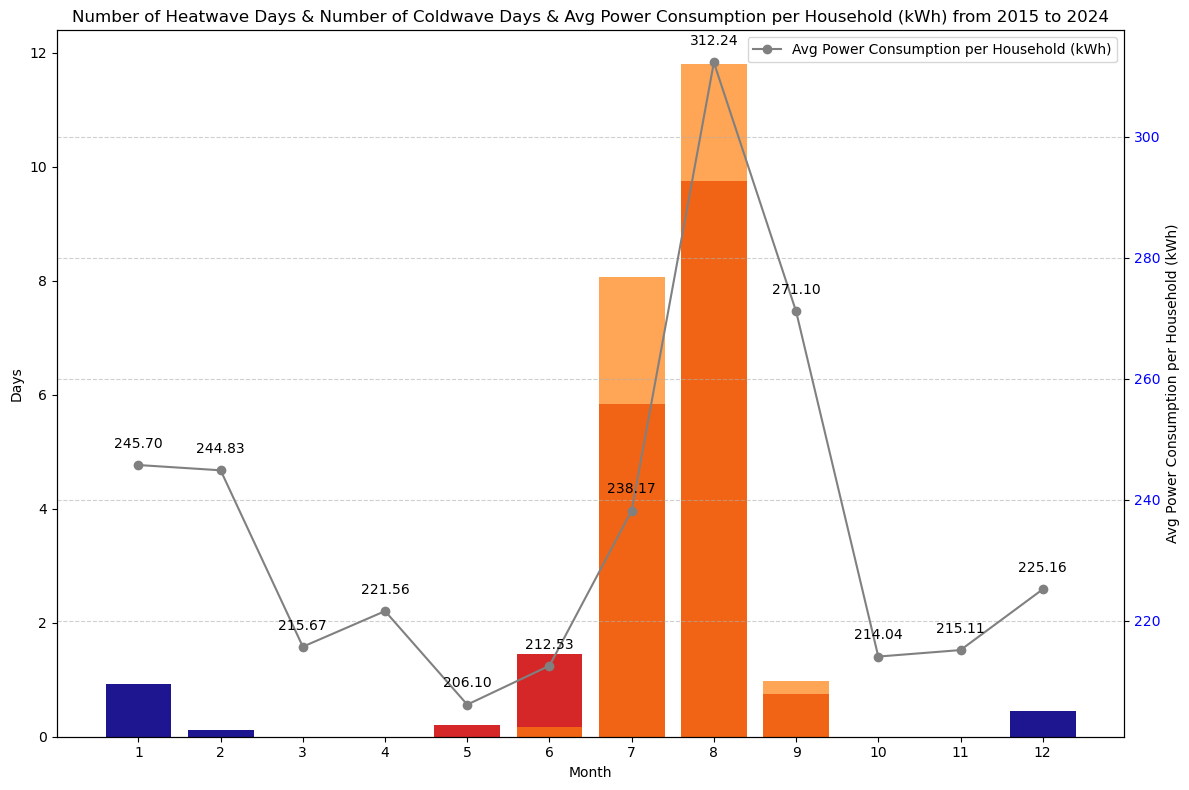

In [ ]:
bar_widths = 0.5
color_a = 'tab:red'
color_b = '#1e1690'
color_c = 'tab:orange'
col_a = 'Number of Heatwave Days'
col_b = 'Number of coldwave Days'
col_c = 'Number of Tropical Nights'
data = df_merged.groupby('Month')[['Number of Heatwave Days', 'Number of Coldwave Days','Number of Tropical Nights']].mean().reset_index()
data_mean = df_merged.groupby('Month')[['Avg Power Consumption per Household (kWh)']].mean().reset_index()
fig, ax_1 = plt.subplots(figsize=(12, 8))
months = data['Month'].unique()
x = np.arange(len(months))
rects1 = ax_1.bar(data['Month'], data['Number of Heatwave Days'],label=col_a , color=color_a)
rects2 = ax_1.bar(data['Month'],  data['Number of Coldwave Days'],label=col_b, color=color_b)
rects3 = ax_1.bar(data['Month'],data['Number of Tropical Nights'],label=col_c,color=color_c,alpha=0.7)
ax_1.set_xticks(data['Month'])
ax_1.set_xlabel('Month')
ax_1.set_ylabel('Days')
ax_1.tick_params(axis='y', labelcolor='black')

#######
col_d = 'Avg Power Consumption per Household (kWh)'
ax_2 = ax_1.twinx()
ax_2.set_ylabel('Avg Power Consumption per Household (kWh)')
plot_c=ax_2.plot(data_mean['Month'], data_mean['Avg Power Consumption per Household (kWh)'], marker='o', color='grey',label=col_d )
ax_2.tick_params(axis='y', labelcolor='blue')
for x_val,y_val in zip(data_mean['Month'],data_mean['Avg Power Consumption per Household (kWh)']):
	ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=10,color='black')
plt.title(f'Number of Heatwave Days & Number of Coldwave Days & Avg Power Consumption per Household (kWh) from 2015 to 2024')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.tight_layout()
handles_to_combine = [rects1, rects2,rects3] + plot_c
labels_to_combine = [h.get_label() for h in handles_to_combine]
ax_1.legend(handles_to_combine, labels_to_combine,
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

In [84]:
# Sunshine and avg cloud cover by month
# dual_features_plot(a='Sunshine Rate (%)', b='Avg Cloud Cover (1/10)', c='Month')
dual_features_plot(a='Avg Cloud Cover (1/10)', b='Sunshine Rate (%)', c='Month')

In [75]:
#Monthly sunlight and evaporation
# dual_features_plot(a='Sunshine Rate (%)', b='Small Pan Evaporation (mm)', c='Month')

dual_features_plot(a='Small Pan Evaporation (mm)', b='Sunshine Rate (%)', c='Month')

In [83]:
#Monthly Avg Wind Speed and evaporation
# dual_features_plot(a='Avg Wind Speed (m/s)', b='Small Pan Evaporation (mm)', c='Month')

dual_features_plot(a='Small Pan Evaporation (mm)', b='Avg Wind Speed (m/s)', c='Month')

In [ ]:
# Monthly ground temp plot(month)
df=df_merged.copy()
#Avg Ground Temp (Celsius)  
df_sum=df.groupby('Month')['Avg Ground Temp (Celsius)'].sum()
df_mean=df.groupby('Month')['Avg Ground Temp (Celsius)'].mean()
plt.figure(figsize=(12, 8))
df_mean.plot(kind='line',marker='o')
plt.xticks(df_mean.index)
plt.xlabel('Month')
plt.ylabel('Avg Ground Temp')
plt.title('Monthly ground temp plot')
for x_val, y_val in df_mean.items():
	plt.text(x_val+0.1,y_val+0.55,f'{y_val:.1f}',ha='center',va='bottom',fontsize=10)
plt.grid()
plt.show()

In [41]:
one_feature_two_group('Location','Month','Number of Heatwave Days')

In [42]:
one_feature_two_group('Location','Year','Avg Power Consumption per Household (kWh)')

In [43]:
df_merged['Total Power Consumption (kWh)'] = df_merged['Number of Households'] * df_merged['Avg Power Consumption per Household (kWh)']
one_feature_two_group('Location','Year','Total Power Consumption (kWh)')
df_merged = df_merged.drop(columns=['Total Power Consumption (kWh)'])

In [80]:
# Precipitation by Location

one_feature_two_group('Location','Year','Monthly Precipitation (mm)')

### **Data Preprocessing**

- Preprocessing steps safe to do before splitting
<br>

	- Remove obvious duplicates
	- Fix incorrect labels
	- Drop irrelevant columns
	- Basic data cleaning such as fixing typos or unifying units
	- Handling missing data if not based on global statistics such as dropping rows w/ missing target
	- Changing boolean type to 0 / 1
</br>

- Preprocessing steps that should happen after train-test split
<br>
	- Feature scaling / Normalisation
	- Encoding categorical variables
	- Dimensionality reduction
	- Outlier detection (if model is sensitive)
	- Feature selection based on correlation or variance
	- Creating time-based features if it involves future data
	- Data augmentation
</br>

In [ ]:
# Drop columns unnecessary for training
df_merged = df_merged.drop(columns=['Date'])

In [101]:
# Data split for features and target
X = df_merged.drop(columns=['Avg Power Consumption per Household (kWh)'])
y = df_merged['Avg Power Consumption per Household (kWh)']

In [102]:
# Grab column names of each data type
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
datetime_cols = X.select_dtypes(include=['datetime']).columns
target_col = y.name

In [103]:
# Data split for train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Location label encoding
label_encoder = LabelEncoder()
for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])
    
# Scaling
scaler=StandardScaler()
X_train[numerical_cols]=scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols]=scaler.transform(X_test[numerical_cols])


In [104]:
# Check multicolinearity using VIF on training data
df_vif = pd.DataFrame()
df_vif['feature'] = X_train.columns
df_vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
df_vif

In [116]:
# Drop columns w/ high VIF
X_train = X_train.drop(columns=['Year', 'Month', 'Location', 'Avg Temperature (Celsius)', 'Avg Dew Point Temp (Celsius)', 'Avg Min Surface Temp (Celsius)'])
X_test = X_test.drop(columns=['Year', 'Month', 'Location', 'Avg Temperature (Celsius)', 'Avg Dew Point Temp (Celsius)', 'Avg Min Surface Temp (Celsius)'])

# Re-check multicolinearity
df_vif_removed = pd.DataFrame()
df_vif_removed['feature'] = X_train.columns
df_vif_removed['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train_vif.shape[1])]
df_vif_removed

In [117]:
# PCA
pca = PCA()
pca.fit_transform(X_train)

# Find the features that contributes the most to PC 1 and PC 2 
weights_pca = abs(pca.components_)
top_pc1_idx = np.argsort(weights_pca[0])[::-1][:15]
top_pc1_name = [X_train.columns[i] for i in top_pc1_idx]

# Grab features that contribute to PC 1 and PC 2
top_features = list(set(top_pc1_name))
pca_corr = X_train[top_features].corrwith(y_train)
pca_corr

# Drop columns w/ low contributions to PC 1
X_train_pca = X_train[top_features]
X_test_pca = X_test[top_features]

### **Modelling**

Run different machine learning models w/ hyperparameter tunings. <br>
Comparison of errors using RMSE, MAE, R^2 , and adjusted R^2.
R^2 always increases when there are more features, so adjusted R^2 will penalise that impact.

In [108]:
def adj_r2_score(y_true, y_pred, p=X.shape[1]):
    """
    Compute the Adjusted R² (coefficient of determination).

    Adjusted R² adjusts the regular R² score for the number of predictors (features)
    in the model. It penalizes the R² score for adding unnecessary predictors, helping
    to avoid overfitting.

    Parameters:
    - y_true : array-like of shape (n_samples,)
        True target values.
    - y_pred : array-like of shape (n_samples,)
        Predicted target values from the model.
    - p : int
        Number of predictors (features) used in the model. Default is taken from X.shape[1],
        assuming X is defined in the global scope.

    Returns:
    - adj_r2 : float
        The adjusted R² score.
    """
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)

In [ ]:
# Linear regression
# Modelling
start_time = time.time()
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

# Evaluation
y_pred_linear_regression = linear_regression.predict(X_test)
rmse_linear_regression = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_linear_regression))
mae_linear_regression = mean_absolute_error(y_true=y_test, y_pred=y_pred_linear_regression)
r2_linear_regression = r2_score(y_true=y_test, y_pred=y_pred_linear_regression)
adj_r2_linear_regression = adj_r2_score(y_true=y_test, y_pred=y_pred_linear_regression)
print(f"RMSE of linear regression model: {rmse_linear_regression}")
print(f"MAE of linear regression model: {mae_linear_regression}")
print(f"R^2 of linear regression model: {r2_linear_regression}")
print(f"Adjusted R^2 of linear regression model: {adj_r2_linear_regression}")

In [ ]:
# Elastic net
# Hyperparameter tuning
start_time = time.time()
param_grid_elastic_net = {'alpha': [0.1, 1, 10],
						  'l1_ratio': [0.1, 0.5, 0.9]}
grid_elastic_net = GridSearchCV(estimator=ElasticNet(), 
								param_grid=param_grid_elastic_net, 
								cv=5)
grid_elastic_net.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

# Best model
elastic_net_best_alpha = grid_elastic_net.best_params_['alpha']
elastic_net_best_l1_ratio = grid_elastic_net.best_params_['l1_ratio']
elastic_net_best_model = grid_elastic_net.best_estimator_
print(f"Best alpha: {elastic_net_best_alpha} | Best l1_ratio: {elastic_net_best_l1_ratio}")

# Evaluation
y_pred_elastic_net = elastic_net_best_model.predict(X_test)
rmse_elastic_net = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_elastic_net))
mae_elastic_net = mean_absolute_error(y_true=y_test, y_pred=y_pred_elastic_net)
r2_elastic_net = r2_score(y_true=y_test, y_pred=y_pred_elastic_net)
adj_r2_elastic_net = adj_r2_score(y_true=y_test, y_pred=y_pred_elastic_net)
print(f"RMSE of elastic net model: {rmse_elastic_net}")
print(f"MAE of elastic net model: {mae_elastic_net}")
print(f"R^2 of elastic net model: {r2_elastic_net}")
print(f"Adjusted R^2 of elastic net model: {adj_r2_elastic_net}")


In [ ]:
# SVR
start_time = time.time()

# SVR 모델 학습 (RBF 커널 사용)
hyperparams = {'kernel': ['poly', 'rbf', 'sigmoid'],
			   'C':[10, 100, 1000],
			   'epsilon':[0.3,0.5,0.8]}

model_SVR = GridSearchCV(estimator=SVR(),
			 			 param_grid=hyperparams,
			 			 cv=5)
model_SVR.fit(X_train, y_train)

# regressor = SVR(kernel='rbf', C=100, epsilon=0.1)
# regressor.fit(X_train, y_train) 

end_time = time.time()

print(f"Training time: {end_time - start_time: .4f}")

# 예측
best_model = model_SVR.best_estimator_  #여기 보시면 best_estimator은 위에 Grid SEarch에서 훈련이된 모
best_kernel = model_SVR.best_params_['kernel']
best_C = model_SVR.best_params_['C']
best_epsilon = model_SVR.best_params_['epsilon']
y_pred_SVR = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_SVR)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_SVR))
r2_SVR = r2_score(y_true=y_test,y_pred=y_pred_SVR)
adj_r2_SVR = adj_r2_score(y_true=y_test,y_pred=y_pred_SVR)

print(f"MSE: {mse}")
print(f"RMSE :{rmse}")
print(f"R^2 of SVR model: {r2_SVR}")
print(f"Adjusted R^2 of SVR model: {adj_r2_SVR}")
print(f"best_kernel : {best_kernel}")
print(f"best_C : {best_C}")
print(f"best_epsilon : {best_epsilon}")

In [133]:
# Decision tree
# Model
start_time=time.time()


Hyperparams = {'criterion':['absolute_error','squared_error'],
                'max_depth':[4,6,None],
                'min_samples_leaf': [1, 2, 4]}

grid_DT = GridSearchCV(estimator=DecisionTreeRegressor(),
                       param_grid = Hyperparams,
                       cv=5)
                       
grid_DT.fit(X_train,y_train)


end_time = time.time()
print(f"Traning time :{end_time - start_time : .4f}")
# Testing
# y_pred_DT = DT.predict(X_test)  #현재 DT는 훈련이 되어있지않는 모델입니다. 위에 SVR모델 오시겠어요? 현
# Best model
best_model = grid_DT.best_estimator_
best_criterion = grid_DT.best_params_['criterion']
best_max_depth = grid_DT.best_params_['max_depth']
best_min_samples_leaf = grid_DT.best_params_['min_samples_leaf']
y_pred_DT = best_model.predict(X_test)


mse = mean_squared_error(y_test,y_pred_DT)

rmse = math.sqrt(mean_squared_error(y_test, y_pred_DT))

r2_DT = r2_score(y_true=y_test,y_pred=y_pred_DT)

adj_r2_DT = adj_r2_score(y_true=y_test,y_pred=y_pred_DT)


print(f"MSE:{mse}")
print(f"RMSE:{rmse}")
print(f"R^2 of DT model :{r2_DT}")
print(f"Adjusted R^2 of DT model:{adj_r2_DT}")
print(f"best_criterion:{best_criterion}")
print(f"best_max_dept :{best_max_depth}")

In [ ]:
# Decision tree
#Gridsearch
start_time = time.time()
DT_param_grid = {
    'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_search_DT = GridSearchCV(estimator=DecisionTreeRegressor(),
                               param_grid=DT_param_grid,
                               cv=5,
                               verbose=2)
grid_search_DT.fit(X_train,y_train)
print(f"best_params: {grid_search_DT.best_params_}")
DT_reg=grid_search_DT.best_estimator_
DT_reg.fit(X_train,y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

DT_y_pred= DT_reg.predict(X_test)

DT_mse=mean_squared_error(y_test,DT_y_pred)

DT_mae=mean_absolute_error(y_test,DT_y_pred)
print(f'MAE:{DT_mae: .4f}')

DT_rmse = np.sqrt(DT_mse)
print(f'RMSE:{DT_rmse: .4f}')

R2= r2_score(y_test,DT_y_pred)
print(f'R²:{R2: .4f}')

adj_r2= adj_r2_score(y_test,DT_y_pred)
print(f'adj-R²:{adj_r2 : .4f}')


DT_model = pd.DataFrame({'y_test':y_test,'y_pred':DT_y_pred})
DT_model['MAE'] = DT_mae
DT_model['RMSE'] = DT_rmse
DT_model['R²'] = R2
DT_model['adj-R²'] = adj_r2
DT_model['Model'] = 'DT'

In [ ]:
#RF
start_time = time.time()
RF = RandomForestRegressor(random_state=42)
RF_param_grid= {'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],   
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],   
    'bootstrap': [True, False],}  
grid_search_RF = GridSearchCV(estimator=RF,
                               param_grid=RF_param_grid,
                               cv=5)
grid_search_RF.fit(X_train,y_train)
print(f"best_params: {grid_search_RF.best_params_}")
RF_reg=grid_search_RF.best_estimator_
RF_reg.fit(X_train,y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

RF_y_pred= RF_reg.predict(X_test)

RF_mse=mean_squared_error(y_test,RF_y_pred)

RF_mae=mean_absolute_error(y_test,RF_y_pred)
print(f'MAE:{RF_mae: .4f}')

RF_rmse = np.sqrt(RF_mse)
print(f'RMSE:{RF_rmse: .4f}')

RF_R2= r2_score(y_test,RF_y_pred)
print(f'R²:{RF_R2: .4f}')

RF_adj_r2= adj_r2_score(y_test,RF_y_pred)
print(f'adj-R²:{RF_adj_r2 : .4f}')


RF_model = pd.DataFrame({'y_test':y_test,'y_pred':RF_y_pred})
RF_model['MAE'] = RF_mae
RF_model['RMSE'] = RF_rmse
RF_model['R²'] = RF_R2
RF_model['adj-R²'] =RF_adj_r2
RF_model['Model'] = 'RF'


ValueError: 
All the 810 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 348, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/pandas/core/generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Daegu'

--------------------------------------------------------------------------------
648 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 348, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/pandas/core/generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Incheon'


In [ ]:
# y_pred_elastic_net
# elas_mse=mean_squared_error(y_test,y_pred_elastic_net)

# elas_mae=mean_absolute_error(y_test,y_pred_elastic_net)
# print(f'MAE:{elas_mae: .4f}')

# elas_rmse = np.sqrt(elas_mse)
# print(f'RMSE:{elas_rmse: .4f}')

# elas_R2= r2_score(y_test,y_pred_elastic_net)
# print(f'R²:{elas_R2: .4f}')

# elas_adj_r2= adj_r2_score(y_test,y_pred_elastic_net)
# print(f'adj-R²:{elas_adj_r2 : .4f}')


# elas_model = pd.DataFrame({'y_test':y_test,'y_pred':y_pred_elastic_net})
# elas_model['MAE'] = elas_mae
# elas_model['RMSE'] = elas_rmse
# elas_model['R²'] = elas_R2
# elas_model['adj-R²'] =elas_adj_r2
# elas_model['Model'] = 'elas'

# Lr=y_pred_linear_regression
# Lr_mse=mean_squared_error(y_test,Lr)

# Lr_mae=mean_absolute_error(y_test,Lr)
# print(f'MAE:{Lr_mae: .4f}')

# Lr_rmse = np.sqrt(Lr_mse)
# print(f'RMSE:{Lr_rmse: .4f}')

# Lr_R2= r2_score(y_test,Lr)
# print(f'R²:{Lr_R2: .4f}')

# Lr_adj_r2= adj_r2_score(y_test,Lr)
# print(f'adj-R²:{Lr_adj_r2 : .4f}')


# Lr_model = pd.DataFrame({'y_test':y_test,'y_pred':Lr})
# Lr_model['MAE'] = Lr_mae
# Lr_model['RMSE'] = Lr_rmse
# Lr_model['R²'] = Lr_R2
# Lr_model['adj-R²'] =Lr_adj_r2
# Lr_model['Model'] = 'Lr'

# VCR_y_pred= regressor.predict(X_test)

# VCR_mse=mean_squared_error(y_test,y_pred)

# VCR_mae=mean_absolute_error(y_test,VCR_y_pred)
# print(f'MAE:{VCR_mae: .4f}')

# VCR_rmse = np.sqrt(VCR_mse)
# print(f'RMSE:{VCR_rmse: .4f}')

# VCR_R2= r2_score(y_test,VCR_y_pred)
# print(f'R²:{RF_R2: .4f}')

# VCR_adj_r2= adj_r2_score(y_test,VCR_y_pred)
# print(f'adj-R²:{RF_adj_r2 : .4f}')


# VCR_model = pd.DataFrame({'y_test':y_test,'y_pred':VCR_y_pred})
# VCR_model['MAE'] = VCR_mae
# VCR_model['RMSE'] = VCR_rmse
# VCR_model['R²'] = VCR_R2
# VCR_model['adj-R²'] =VCR_adj_r2
# VCR_model['Model'] = 'VCR'

In [ ]:
#Ada
start_time = time.time()
Ada = AdaBoostRegressor(random_state=42)
Ada_param_grid = {
    'n_estimators': [30,50,100],
    'learning_rate': [0.01,0.005,0.001],
}
grid_search_Ada = GridSearchCV(estimator=Ada,
                               param_grid=Ada_param_grid,
                               cv=5)
grid_search_Ada.fit(X_train,y_train)
print(f"best_params: {grid_search_Ada.best_params_}")
Ada_reg=grid_search_Ada.best_estimator_
Ada_reg.fit(X_train,y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

Ada_y_pred= Ada_reg.predict(X_test)

Ada_mse=mean_squared_error(y_test,Ada_y_pred)

Ada_mae=mean_absolute_error(y_test,Ada_y_pred)
print(f'MAE:{Ada_mae: .4f}')

Ada_rmse = np.sqrt(Ada_mse)
print(f'RMSE:{Ada_rmse: .4f}')

Ada_R2= r2_score(y_test,Ada_y_pred)
print(f'R²:{Ada_R2: .4f}')

Ada_adj_r2= adj_r2_score(y_test,Ada_y_pred)
print(f'adj-R²:{Ada_adj_r2 : .4f}')


Ada_model = pd.DataFrame({'y_test':y_test,'y_pred':Ada_y_pred})
Ada_model['MAE'] = Ada_mae
Ada_model['RMSE'] = Ada_rmse
Ada_model['R²'] = Ada_R2
Ada_model['adj-R²'] =Ada_adj_r2
Ada_model['Model'] = 'Ada'

In [ ]:
# X_train_copy=X_train.copy()
X_test_copy = X_test.copy()
X_train_corr=pd.concat([X_train,y_train],axis=1,join='inner')
X_train_copy=X_train_copy.drop(columns=low_cols)
X_test_copy = X_test_copy.drop(columns=low_cols)# # # # 

In [ ]:
#heatmap
df_numeric=X_train_corr.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
df_corr_find = df_corr.copy()
low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index #Features with low correlation with the target data
print(low_cols)
 #important features in low_cols? (Before delete low_cols result: MAE:5.3,RMSE:8.1,R²:0.96,adj-R²:0.91,After delete low_cols result: MAE:9.3,RMSE:13.4,R²:0.76,adj-R²:0.72)# # # # # 

Index(['Year', 'Month', 'Location', 'Number of Households',
       'Number of Coldwave Days', 'Small Pan Evaporation (mm)',
       'Avg Wind Speed (m/s)', 'Max Wind Speed (m/s)'],
      dtype='object')


In [ ]:
# start_time = time.time()
xgb = XGBRegressor()
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

grid_search_xgb = GridSearchCV(estimator=xgb,
                               param_grid=param_grid_xgb,
                               cv=5,
                               verbose=2)
grid_search_xgb.fit(X_train,y_train)
print(f"best_params: {grid_search_xgb.best_params_}")
xgb_reg=grid_search_xgb.best_estimator_
xgb_reg.fit(X_train,y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

xgb_y_pred= xgb_reg.predict(X_test)

xgb_mse=mean_squared_error(y_test,xgb_y_pred)

xgb_mae=mean_absolute_error(y_test,xgb_y_pred)
print(f'MAE:{xgb_mae: .4f}')

xgb_rmse = np.sqrt(xgb_mse)
print(f'RMSE:{xgb_rmse: .4f}')

xgb_R2= r2_score(y_test,xgb_y_pred)
print(f'R²:{xgb_R2: .4f}')

xgb_adj_r2= adj_r2_score(y_test,xgb_y_pred)
print(f'adj-R²:{xgb_adj_r2 : .4f}')


xgb_model = pd.DataFrame({'y_test':y_test,'y_pred':xgb_y_pred})
xgb_model['MAE'] = xgb_mae
xgb_model['RMSE'] = xgb_rmse
xgb_model['R²'] = xgb_R2
xgb_model['adj-R²'] =xgb_adj_r2
xgb_model['Model'] = 'xgb'

best_params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Training time:  275.8497
MAE: 9.3430
RMSE: 13.4025
R²: 0.7655
adj-R²: 0.7203


In [ ]:
DT_RF=pd.concat([DT_model,RF_model,VCR_model,elas_model,Lr_model,Ada_model,xgb_model])#DT_model,RF_model,VCR_model,elas_model,Lr_model,Ada_model
DT_RF=DT_RF.sort_values(by=["y_test"], ascending=[True]) 
pd.options.display.float_format = '{:.2f}'.format
DT_RF.head(14)

NameError: name 'VCR_model' is not defined

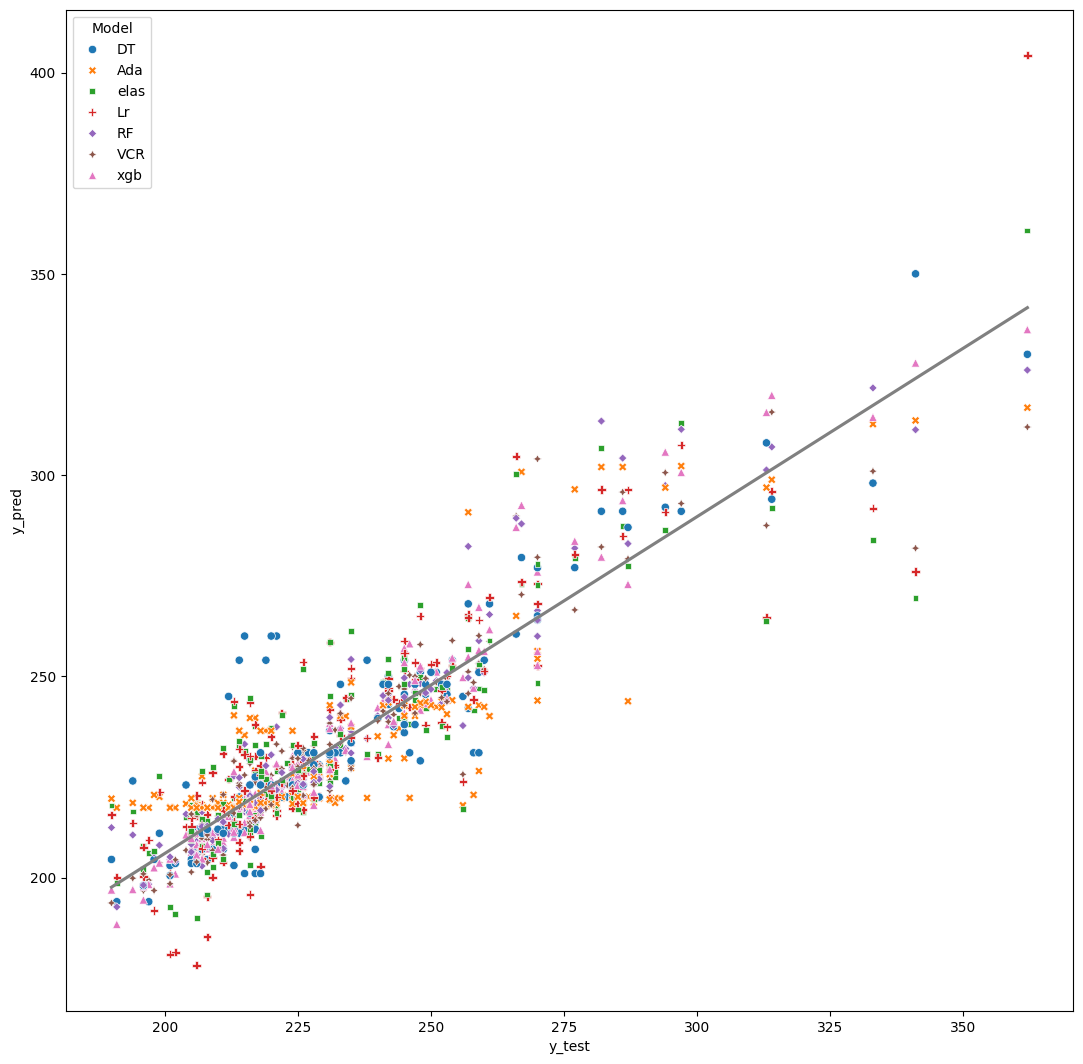

: 

: 

In [ ]:
# plt.figure(figsize=(13, 13)) 
# sns.regplot(data=DT_RF,x='y_test', y='y_pred',scatter=False, ci=None, color='gray')
# sns.scatterplot(data=DT_RF, x='y_test', y='y_pred', hue='Model',style='Model')

# plt.show()

Epoch 1/10


/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 55868.5703 - mse: 55868.5703 - val_loss: 57217.3086 - val_mse: 57217.3086
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53959.2266 - mse: 53959.2266 - val_loss: 54284.2617 - val_mse: 54284.2617
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51193.8477 - mse: 51193.8477 - val_loss: 45552.5742 - val_mse: 45552.5742
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40863.3438 - mse: 40863.3438 - val_loss: 25252.0215 - val_mse: 25252.0215
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17631.8672 - mse: 17631.8672 - val_loss: 7288.8613 - val_mse: 7288.8613
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5699.1450 - mse: 5699.1450 - val_loss: 5208.4868 - val_mse: 5208.4868
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4064.8955 - mse: 4064.8955 - val_loss: 4320.9561 - val_mse: 4320.9561
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2988.2839 - mse: 2988.2839 - val_loss: 

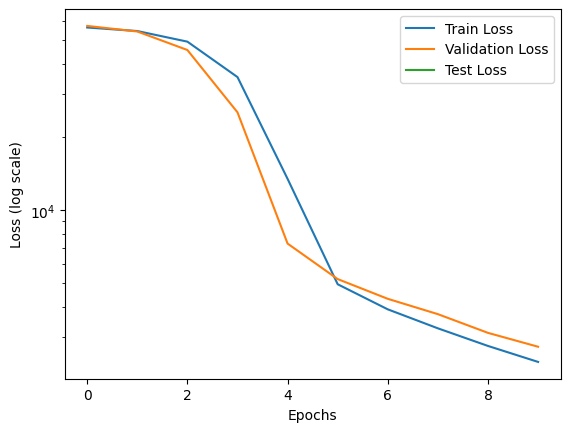

: 

: 

In [ ]:
# NN
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse',metrics=['mse'])

A = model.fit(X_train, y_train, epochs=800, batch_size=16, validation_data=(X_valid, y_valid))
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# 손실값 그래프 

# Test Loss 추가 (마지막 epoch 기준 고정)
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.plot(A.history['loss'], label='Train Loss')  
plt.plot(A.history['val_loss'], label='Validation Loss')  
 
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.yscale('log') 
plt.legend()
plt.show()


In [ ]:
##NN start_time

start_time = time.time()

history = model.fit(X_train, y_train, epochs=120, batch_size=16,
                    validation_data=(X_test, y_test), verbose=1)


y_pred_NN = model.predict(X_test)


rmse_NN = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_NN))
mae_NN = mean_absolute_error(y_true=y_test, y_pred=y_pred_NN)
adj_r2_NN = adj_r2_score(y_true=y_test, y_pred=y_pred_NN)

end_time = time.time()

print(f"Training time: {end_time - start_time: .4f} \n")
print(f"R-squared (R²): {adj_r2_NN} \n")
print(f"mae_NN : {mae_NN } \n")
print(f"rmse_NN: {mae_NN } \n")



: 

: 

# NN
Training time:  35.1087 

R-squared (R²): 0.7483844955762227 

mae_NN : 7.945088863372803 

rmse_NN: 7.945088863372803 

### **Time Series Analysis**

In [ ]:
# Load file
df = pd.read_csv('data/merged_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Year', 'Month'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
y = df['Avg Power Consumption per Household (kWh)']
y = y.resample('MS').mean()

In [ ]:
# Check stationarity using Augmented Dickey-Fuller test
adf = adfuller(y.dropna())
print(f"ADF stats: {adf[0]} | p-val: {adf[1]}")

ADF stats: -0.21625904278285144 | p-val: 0.9365556288116558


In [ ]:
# Split into train and test data
date = '2023-01-01'
y_train, y_test = y[:date], y[date:]

In [ ]:
# SARIMAX
sarimax = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax.fit()
print(sarimax_fit.summary())

                                           SARIMAX Results                                           
Dep. Variable:     Avg Power Consumption per Household (kWh)   No. Observations:                   97
Model:                        SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -339.041
Date:                                       Thu, 03 Apr 2025   AIC                            688.082
Time:                                               11:39:42   BIC                            700.236
Sample:                                           01-01-2015   HQIC                           692.968
                                                - 01-01-2023                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1944     

In [ ]:
# Forecast
y_pred = sarimax_fit.forecast(steps=len(y_test))
y_pred.index = y_test.index + pd.DateOffset(months=1)

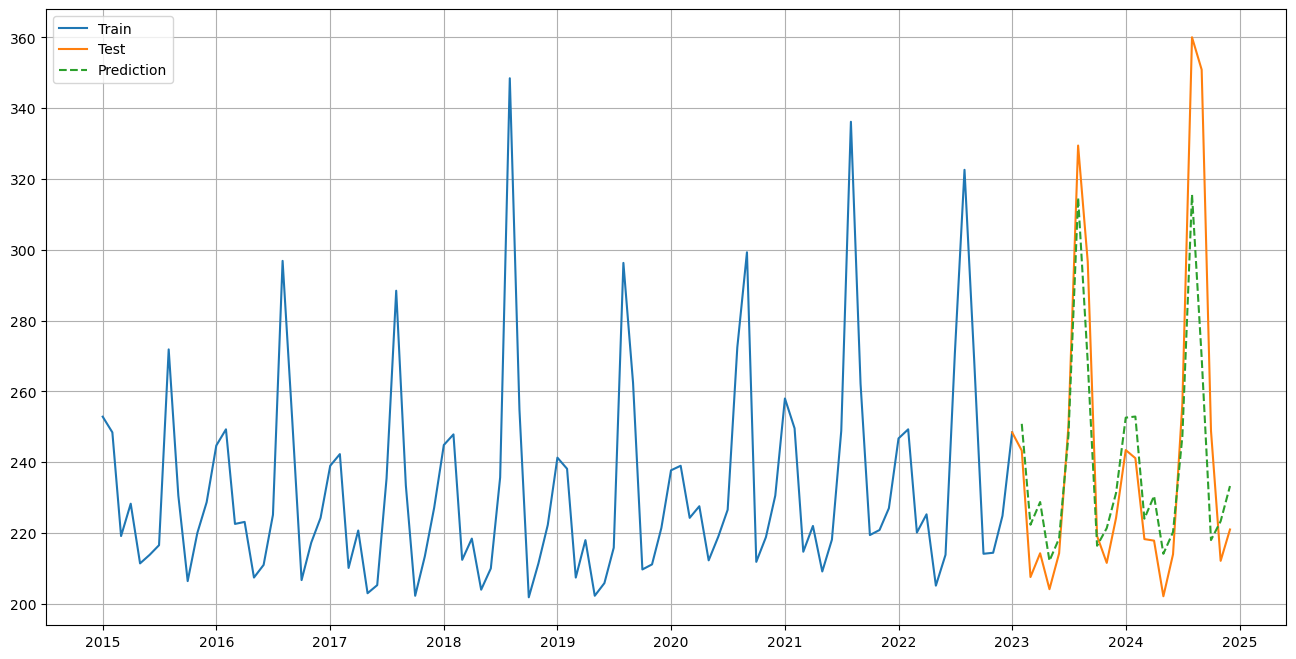

In [ ]:
# Forecast
plt.figure(figsize=(16, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred[:-1], label='Prediction', linestyle='--')
plt.legend()
plt.grid()
plt.show()